We spell out the computational details of the paper "A single entangled system is an unbounded source of nonlocal correlations and of certified random numbers," published in the Proceedings of [TQC-17](http://tqc2017.lip6.fr/), which is an extended version of [Unbounded randomness certification using sequences of measurements](https://doi.org/10.1103/PhysRevA.95.020102) ([arXiv:1510.03394](https://arxiv.org/abs/1510.03394)). Calculations were performed at arbitrary precision with the SDP solver [SDPA-GMP](http://sdpa.sourceforge.net/), and it is assumed that the executable binary is in the path. We import the rest of the dependencies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product
from math import sqrt, sin, cos, pi, atan
from qutip import tensor, basis, sigmax, sigmaz, expect, qeye
from ncpol2sdpa import SdpRelaxation, flatten, generate_measurements, \
                       projective_measurement_constraints
π = pi

First we define the state and the measurements in the observed probability distribution.  Here we work in the standard scenario with only one measurement $n = 1$ in the sequence. We used states of the form 
$$
|\psi(\theta)\rangle = \cos(\theta)|00\rangle+\sin(\theta)|11\rangle
$$

and measurements:

$$
\mathbb{A}_0 = \cos\mu\,\sigma_z + \sin\mu\,\sigma_x, \hspace{1cm} \mathbb{B}_0 = \sigma_z, \\
\mathbb{A}_1 = \cos\mu\,\sigma_z - \sin\mu\,\sigma_x, \hspace{1cm} \mathbb{B}_1 = \hat{\sigma}_x(\xi)=\cos(2\xi)\sigma_x,
$$
that correspond to the ones in our scheme for an unbounded amount of randomness and where the second measurement $y = 1$ of $B$ is the tunable version $\hat{\sigma}_x(\xi)\equiv\{M_{+1}^{\dagger}M_{+1},M_{-1}^{\dagger}M_{-1}\}$:
$$
M_{\pm1}(\xi)=\cos\xi|\pm\rangle\!\langle\pm|+\sin\xi|\mp\rangle\!\langle\mp|.
$$

In [2]:
def get_moments(ξ, θ):
    mu = atan(sin(2*θ))
    psi = (cos(θ) * tensor(basis(2, 0),basis(2, 0)) +
           sin(θ) * tensor(basis(2, 1),basis(2, 1)))
    A_1 = cos(mu)*sigmaz() - sin(mu)*sigmax()
    A_0 = cos(mu)*sigmaz() + sin(mu)*sigmax()

    B_0 = sigmaz()
    B_1 = (qeye(2) + cos(2*ξ)*sigmax())/2

    A_00 = (qeye(2) + A_0)/2
    A_10 = (qeye(2) + A_1)/2
    B_00 = (qeye(2) + B_0)/2
    B_10 = B_1

    p = []
    p.append(expect(tensor(A_00, qeye(2)), psi))
    p.append(expect(tensor(A_10, qeye(2)), psi))
    p.append(expect(tensor(qeye(2), B_00), psi))
    p.append(expect(tensor(qeye(2), B_10), psi))

    p.append(expect(tensor(A_00, B_00), psi))
    p.append(expect(tensor(A_00, B_10), psi))
    p.append(expect(tensor(A_10, B_00), psi))
    p.append(expect(tensor(A_10, B_10), psi))

    moments = ["-0[0,0]-1[0,0]+1"]
    k = 0
    for i in range(len(A_configuration)):
        moments.append(P_0_A[i][0] + P_1_A[i][0] - p[k])
        k += 1
    for i in range(len(B_configuration)):
        moments.append(P_0_B[i][0] + P_1_B[i][0] - p[k])
        k += 1
    for i in range(len(A_configuration)):
        for j in range(len(B_configuration)):
            moments.append(P_0_A[i][0]*P_0_B[j][0] + P_1_A[i][0]*P_1_B[j][0] - p[k])
            k += 1
    return moments

We initialize a level-4 SDP relaxation given the CHSH scenario, assuming that the operators in the two possible behaviours observe the algebra of projective measurements.

In [3]:
level = 4
A_configuration = [2, 2]
B_configuration = [2, 2]

P_0_A = generate_measurements(A_configuration, 'P_0_A')
P_0_B = generate_measurements(B_configuration, 'P_0_B')
P_1_A = generate_measurements(A_configuration, 'P_1_A')
P_1_B = generate_measurements(B_configuration, 'P_1_B')
substitutions = projective_measurement_constraints(P_0_A, P_0_B)
substitutions.update(projective_measurement_constraints(P_1_A, P_1_B))

guessing_probability = - (P_0_B[1][0] - P_1_B[1][0])
sdp = SdpRelaxation([flatten([P_0_A, P_0_B]), flatten([P_1_A, P_1_B])],
                    verbose=0, normalized=False)

We defined a helper function to iterate over a range of different $\xi$ and $\theta$ values.

In [4]:
def iterate_over_parameters(Ξ, Θ):
    result = []
    for ξ, θ in product(Ξ, Θ):
        if sdp.block_struct == []:
            sdp.get_relaxation(level, objective=guessing_probability,
                               momentequalities=get_moments(ξ, θ),
                               substitutions=substitutions,
                               extraobjexpr="-1[0,0]")
        else:
            sdp.process_constraints(momentequalities=get_moments(ξ, θ))
        sdp.solve(solver='sdpa', solverparameters={"executable": "/home/pwittek/bin/sdpa_gmp",
                                                   "paramsfile": "param.gmp.sdpa"})
        result.append({"ξ": ξ, "θ": θ, "primal": sdp.primal, "dual": sdp.dual, "status": sdp.status})
    return result

Finally we define two functions to print out the results as a table, and plot the figure.

In [29]:
def print_latex_table(results):
    range_ = set([result["θ"] for result in results])
    print("$\\xi$ & Bits \\\\")
    for θ in range_:
        print("$\\theta=%.3f$ &  \\\\" % θ)
        for result in results:
            if result["θ"] == θ:
                print("%.3f & %.3f\\\\" % 
                      (result["ξ"], abs(np.log2(-result["primal"]))))

                
def plot_results(results, labels, filename=None):
    domain = sorted(list(set(result["ξ"] for result in results)))
    range_ = sorted(list(set(result["θ"] for result in results)))
    fig, axes = plt.subplots(ncols=1)
    for i, θ in enumerate(range_):
        randomness = [abs(np.log2(-result["primal"])) 
                      for result in results if result["θ"] == θ]
        axes.plot(domain, randomness, label=labels[i])
    axes.set_xlabel("$ξ$")
    axes.set_ylabel("Randomness [bits]")
    axes.legend()
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

We can run the calculations now. If the parameter $\xi = 0$, the four (projective) measurements on any quantum state $|\psi(\theta)\rangle$ with angle $\theta$ generates a behavior $P_{obs}^{\theta}$ leading to the maximal violation of the inequality $I_{\theta}$ for the same value of $\theta$. This implies that extremal nonlocal correlations are generated and we know that a perfect random bit -- equivalently $G(y^{0}=1,P_{obs}) = \frac{1}{2}$ -- is produced. This corresponds to the strongest (projective) version of the measurements. Now, as we increase the parameter $\xi > 0$ of $B$'s $y = 1$ measurement, $\hat{\sigma}_x(\xi)$ gets weaker and the generated correlations cease to be extremal and less than a random bit is produced. At some point, at a particular value $\xi^{\theta}_{\textrm{max}}$ the measurement of $B$ is so weak that we expect the generated correlations to become local. This exact value might depend on the amount of entanglement $\theta$ in the state. The bounds obtained by SDP indicate that this dependency on the angle $\theta$ of the maximal value $\xi^{\theta}_{\textrm{max}}$ is relatively small. As we vary the angle $\theta$, the minimal required strength of the measurement stays within a narrow interval: $\xi^{\theta}_{\textrm{max}} \in [0.519,0.576]$ for $\theta \in [\frac{\pi}{32},\frac{\pi}{4}]$.

In [ ]:
exponents = range(2, 6)
results = iterate_over_parameters(np.linspace(0, π/4, 60), 
                                  [π/2**i for i in exponents] + [0])

Lower bounds on the amount of randomness certified from the quantum state with angles $\theta = 0,\frac{\pi}{32},\frac{\pi}{16},\frac{\pi}{8},\frac{\pi}{4}$ in function of the strength of the measurement $\xi$. The measurement is projective for $\xi = 0$ -- which certifies the maximal amount of randomness -- and is non interacting with the system when $\xi = 1$. It is intriguing to see that for all states with $\theta > 0$ the generated behavior become local at almost the same $\xi_{\textrm{max}} \in [0.519,0.576]$.

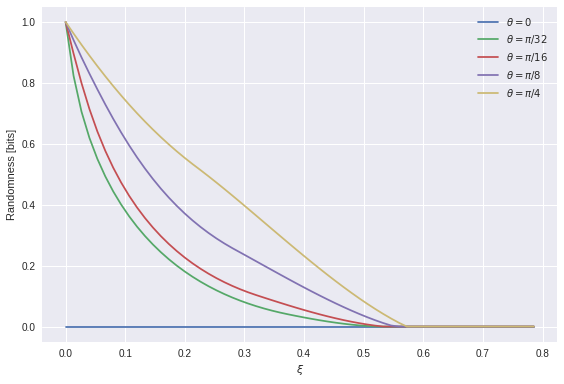

In [32]:
plot_results(results, ["$θ=0$"] + ["$θ=π/%d$" % 2**i for i in sorted(exponents, reverse=True)])